In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1950_bacteria_4881.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1430-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1437-0001.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg
/kaggle/input/chest-xray-pneumo

In [2]:
path_train = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/train'
path_test = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/test'
path_val = '/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val'

In [3]:
def img_list(path):
    imglist = []
    labels = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            imglist.append(os.path.join(dirname, filename))
    return imglist

In [4]:
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
from sklearn.utils import shuffle
from skimage.color import rgb2gray

def plot_imgs(path):
    f = plt.figure(figsize=(10,5))
    imglist = img_list(path)
    rand = random.sample(imglist,3)
    for i,img in enumerate(rand):
        imgarr = imread(img)
        print(imgarr.shape)
        if len(imgarr.shape)==3:
            imgarr = rgb2gray(imgarr)
        f.add_subplot(1,3,i+1)
        plt.subplot(131+i)
        plt.imshow(imgarr,cmap='gray')

NORMAL
(936, 1248)
(1152, 1508)
(1120, 1400)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


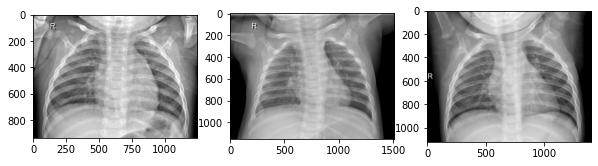

In [5]:
print('NORMAL')
plot_imgs(path_train+'/NORMAL')

PNEUMONIA
(762, 1284)
(800, 1328)
(784, 1360)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


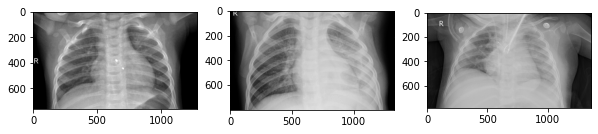

In [6]:
print('PNEUMONIA')
plot_imgs(path_train+'/PNEUMONIA')

In [7]:
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import Conv2D,Dense,MaxPooling2D,Flatten,BatchNormalization,Dropout,Add,Input,Lambda,Concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras import regularizers
import keras.backend as K
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16

Using TensorFlow backend.


In [8]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        validation_split=0.075,
        horizontal_flip=False)
train_generator = train_datagen.flow_from_directory(
        path_train,
        target_size=(224, 224),
        batch_size=128,
        class_mode='binary',
        subset='training')
val_generator = train_datagen.flow_from_directory(
        path_train,
        target_size=(224, 224),
        batch_size=128,
        class_mode='binary',
        subset='validation')

Found 4826 images belonging to 2 classes.
Found 390 images belonging to 2 classes.


In [9]:
def res_block(inputs,filters,i):
    conv_1 = Conv2D(filters=filters,kernel_size=(3,3),padding='same',activation='relu',name=str('conv_'+str(10*i+1)))(inputs)
    conv_2 = Conv2D(filters=filters,kernel_size=(3,3),padding='same',activation='relu',name=str('conv_'+str(10*i+2)))(conv_1)
    conv_3 = Conv2D(filters=filters,kernel_size=(3,3),padding='same',activation='relu',name=str('conv_'+str(10*i+3)))(conv_2)

    add_1 = Add(name=str('add_'+str(i)))([conv_1,conv_3])
    max_1 = MaxPooling2D(pool_size=(2,2),padding='valid',name=str('max_'+str(i)))(add_1)
    return max_1

In [10]:
vgg.summary()

NameError: name 'vgg' is not defined

58892288/58889256 [==============================] - 2s 0us/step


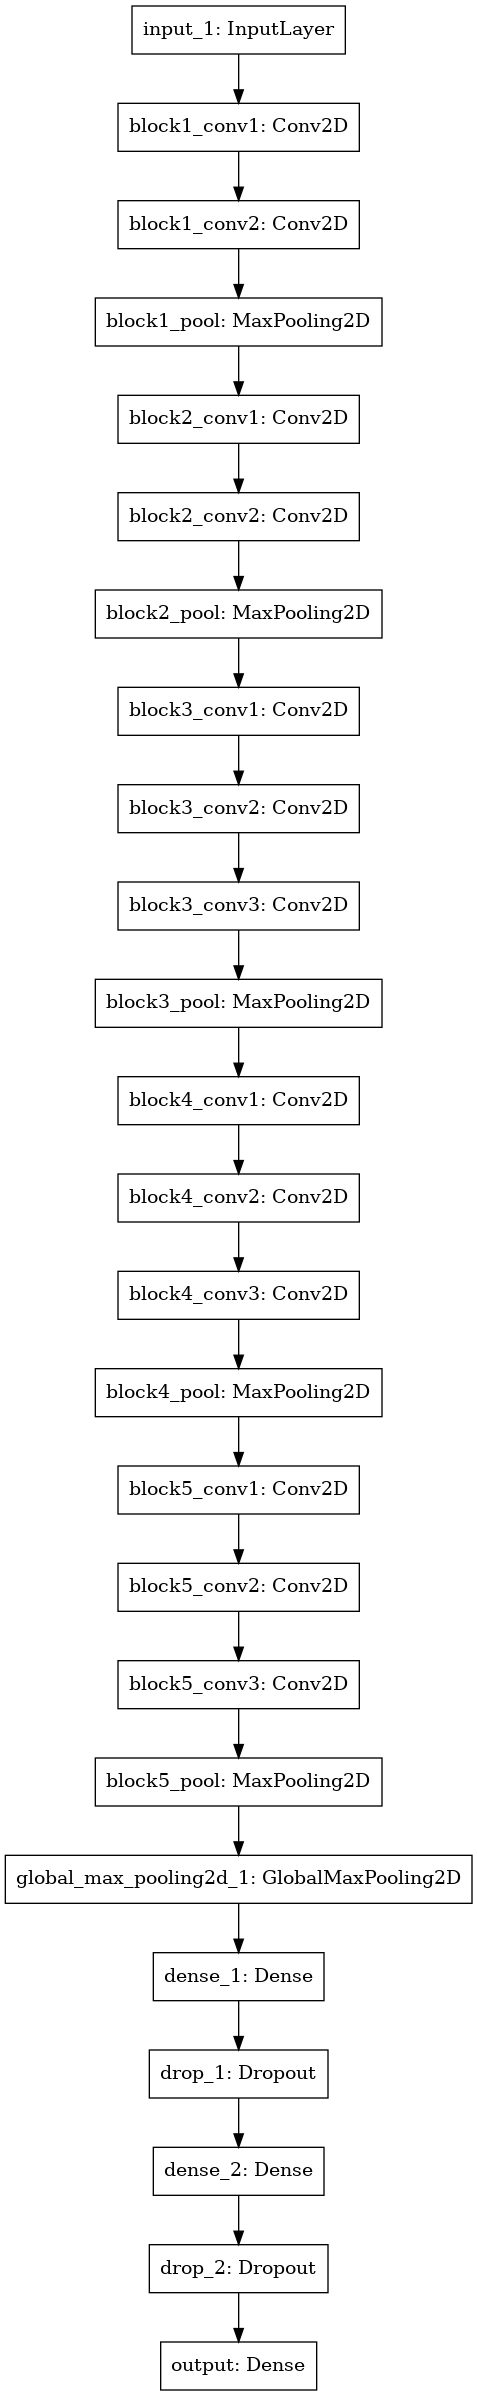

In [11]:
input_imgs  = Input((224,224,3))

vgg = VGG16(include_top=False, input_tensor=input_imgs, pooling='max')
vgg_last = vgg.output

#flat_1 = Flatten(name='flat_3')(vgg_last)
dense_1 = Dense(1024,activation='relu',kernel_regularizer=regularizers.l2(0.01),name='dense_1')(vgg_last)
dense_1 = Dropout(0.5,name='drop_1')(dense_1)
dense_2 = Dense(512,activation='relu',kernel_regularizer=regularizers.l2(0.01),name='dense_2')(dense_1)
dense_2 = Dropout(0.5,name='drop_2')(dense_2)
output = Dense(1,activation='sigmoid',kernel_regularizer=regularizers.l2(0.01),name='output')(dense_2)

model = Model(inputs=input_imgs,outputs=output,name='CNN Model')
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [12]:
for layer in model.layers:
	layer.trainable = False
model.get_layer('dense_1').trainable = True
model.get_layer('dense_2').trainable = True
model.get_layer('output').trainable = True

In [13]:
model.summary()

Model: "CNN Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0 

In [14]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
filepath="weights_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
model.fit_generator(train_generator,validation_data=val_generator,steps_per_epoch=20,epochs=10,verbose=1,callbacks=callbacks_list)

Epoch 1/10
20/20 [==============================] - 63s 3s/step - loss: 10.5505 - accuracy: 0.7443 - val_loss: 6.8294 - val_accuracy: 0.8051

Epoch 00001: val_accuracy improved from -inf to 0.80513, saving model to weights_best.hdf5
Epoch 2/10
20/20 [==============================] - 60s 3s/step - loss: 4.9699 - accuracy: 0.8598 - val_loss: 3.3087 - val_accuracy: 0.8744

Epoch 00002: val_accuracy improved from 0.80513 to 0.87436, saving model to weights_best.hdf5
Epoch 3/10
20/20 [==============================] - 58s 3s/step - loss: 2.5512 - accuracy: 0.8883 - val_loss: 1.7589 - val_accuracy: 0.8923

Epoch 00003: val_accuracy improved from 0.87436 to 0.89231, saving model to weights_best.hdf5
Epoch 4/10
20/20 [==============================] - 58s 3s/step - loss: 1.5556 - accuracy: 0.9092 - val_loss: 1.1540 - val_accuracy: 0.9231

Epoch 00004: val_accuracy improved from 0.89231 to 0.92308, saving model to weights_best.hdf5
Epoch 5/10
20/20 [==============================] - 58s 3s/ste

In [15]:
model.load_weights('weights_best.hdf5')

### **Training Accuracy** ###

In [16]:
train_generator1 = train_datagen.flow_from_directory(
        path_train,
        target_size=(224,224),
        batch_size=128,
        class_mode='binary',
        shuffle=False)  # keep data in same order as labels

model.evaluate_generator(train_generator1)

Found 5216 images belonging to 2 classes.


[0.8198490142822266, 0.9281058311462402]

### **Test Accuracy** ###

In [17]:
test_generator1 = train_datagen.flow_from_directory(
        path_test,
        target_size=(224,224),
        batch_size=128,
        class_mode='binary',
        shuffle=False)  # keep data in same order as labels

model.evaluate_generator(test_generator1)

Found 624 images belonging to 2 classes.


[0.8054807782173157, 0.8253205418586731]

In [18]:
model.save('xray_model_resnet.h5')